In [1]:
#Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from itertools import product
from tensorflow.python.keras import layers
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage.interpolation import map_coordinates

In [2]:
fullsize_training_inputs = np.load('training_inputs.npy')
fullsize_training_ground_truth = np.load('training_ground_truth.npy')
fullsize_testing_inputs = np.load('testing_inputs.npy')
fullsize_testing_ground_truth = np.load('testing_ground_truth.npy')

In [10]:
#Dice the tensor into smaller, square images
def stack_tensor(tensor,num_stack_H,num_stack_W,rotate=False):
    '''
    divides tensor of size (N,H,W,C) into more instances of smaller images (N*n^2,H/n,W/n,C)
    tensor: A four dimensional tensor object or numpy array
    num_stack: number of times to divide width and height
    '''
    #unpack values
    N, H, W, C = tensor.shape
    new_N = N*(num_stack_H*num_stack_W)
    new_H = H//num_stack_H
    new_W = W//num_stack_W
    image_segments = product(range(num_stack_H), range(num_stack_W))
    stacked_tensor = np.empty((new_N,new_H,new_W,C))
    if rotate == True:
        stacked_tensor = np.empty((new_N,new_W,new_H,C))
        tensor = np.swapaxes(tensor,1,2)
        image_segments = product(range(num_stack_W), range(num_stack_H))
        new_H, new_W = new_W, new_H
    new_n=0
    for r, c in image_segments:
        for n in range(N):
            stacked_tensor[new_n,:,:,:] = tensor[n, r*new_H:(r+1)*new_H,c*new_W:(c+1)*new_W,:]
            new_n += 1
    return stacked_tensor

def preprocess_tensor(tensor):
    '''
    Applies common pre-processing transformations and returns the necessary constants 
    to apply the same transforms to validation and test data
    '''
    tensor_mean = np.mean(tensor,axis=0,keepdims=True)
    preprocessed_tensor = tensor - tensor_mean
    return preprocessed_tensor, tensor_mean

In [4]:
training_inputs = stack_tensor(fullsize_training_inputs,3,4)/255
training_ground_truth = stack_tensor(fullsize_training_ground_truth,3,4)/255
testing_inputs = stack_tensor(fullsize_testing_inputs,3,4)/255
testing_ground_truth = stack_tensor(fullsize_testing_ground_truth,3,4)/255
input_shape = training_inputs.shape

del fullsize_training_inputs
del fullsize_training_ground_truth
del fullsize_testing_inputs
del fullsize_testing_ground_truth

In [5]:
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(filters=num_filters,kernel_size=(3, 3),padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(filters=num_filters,kernel_size=(3, 3),padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(filters=num_filters,kernel_size=(2, 2),strides=(2, 2),padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(filters=num_filters, kernel_size=(3, 3),padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(filters=num_filters, kernel_size=(3, 3),padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

In [6]:
inputs = layers.Input(shape = (training_inputs.shape[1:]))
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

W1105 14:02:53.700567 11616 deprecation.py:506] From C:\Users\Malec\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
model = models.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

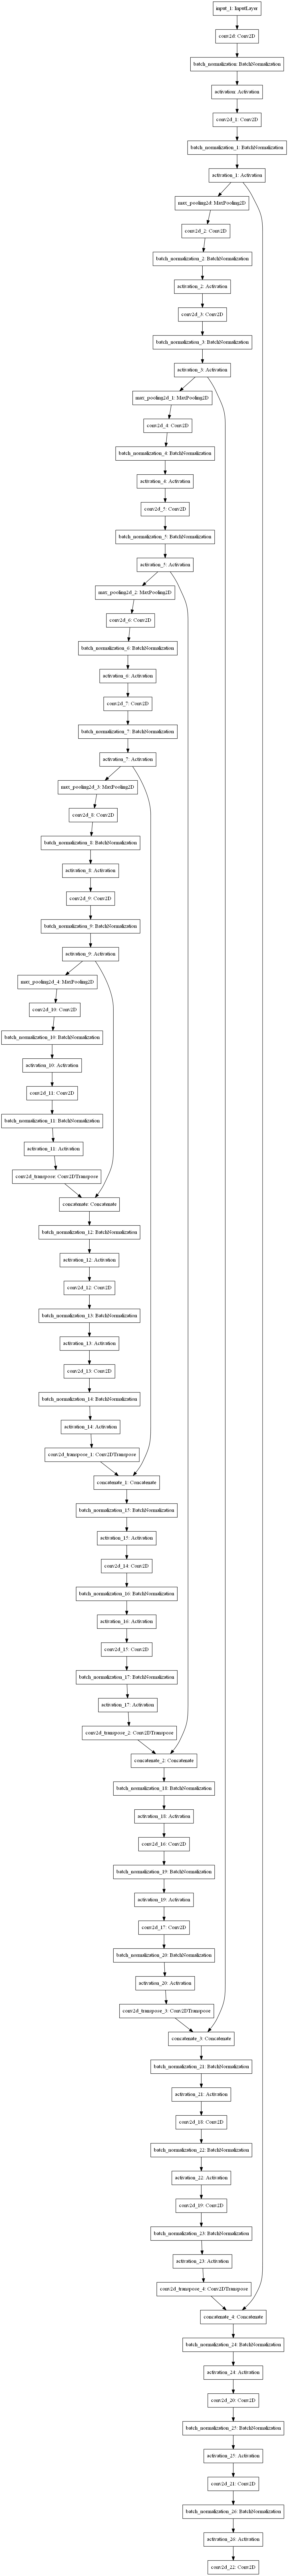

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(model,to_file = 'model_plot.png',rankdir='TB')

In [9]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [11]:
training_inputs, training_mean = preprocess_tensor(training_inputs)

In [12]:
validation_inds = np.random.choice(range(training_inputs.shape[0]),50)
validation_inputs = testing_inputs[validation_inds,:,:,:] - training_mean
validation_ground_truth = testing_ground_truth[validation_inds,:,:,:]

In [16]:
#Initiate Adam optimizer with default values
opt = optimizers.Adam()

#Compile model
model.compile(optimizer=opt, 
              loss=losses.binary_crossentropy, 
              metrics=[dice_coeff])

#Some parameters
epochs = 1
batch_size = 10

#Define a model callback
save_model_path = 'tmp/weights_baseline.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, 
                                        monitor='val_loss',
                                        save_best_only=True, 
                                        verbose=1)

In [14]:
image_datagen = ImageDataGenerator()
mask_datagen = ImageDataGenerator()

train_image_generator = image_datagen.flow(
    training_inputs,
    batch_size=batch_size)

train_mask_generator = mask_datagen.flow(
    training_ground_truth,
    batch_size=batch_size)

train_generator = (pair for pair in zip(train_image_generator,train_mask_generator))

In [17]:
#Fit the model
history = model.fit_generator(train_generator,
                    epochs = epochs,
                    steps_per_epoch = training_inputs.shape[0]//batch_size,
                    validation_data =(validation_inputs, validation_ground_truth),
                    shuffle=True,
                    callbacks=[cp]
                   )

197/198 [============================>.] - ETA: 22s - loss: 0.2163 - dice_coeff: 0.0572
Epoch 00001: val_loss improved from inf to 2.64773, saving model to tmp/weights_baseline.hdf5
198/198 [==============================] - 4392s 22s/step - loss: 0.2166 - dice_coeff: 0.0573 - val_loss: 2.6477 - val_dice_coeff: 0.0980


In [20]:
#Load best model
model.load_weights(save_model_path)
# Score trained model.
possible_test_inds = [i for i in range(training_inputs.shape[0]) if i not in validation_inds]
test_inds = np.random.choice(possible_test_inds,50,replace=False)
scores = model.evaluate(testing_inputs[test_inds,:,:,:]-training_mean, 
                        testing_ground_truth[test_inds,:,:,:], 
                        verbose=1)

print('Test loss:', scores[0],'\n Dice coefficient:', scores[1])

50/50 [==============================] - 10s 192ms/sample - loss: 2.4291 - dice_coeff: 0.0939
Test loss: 2.4290732383728026 
 Dice coefficient: 0.093900114


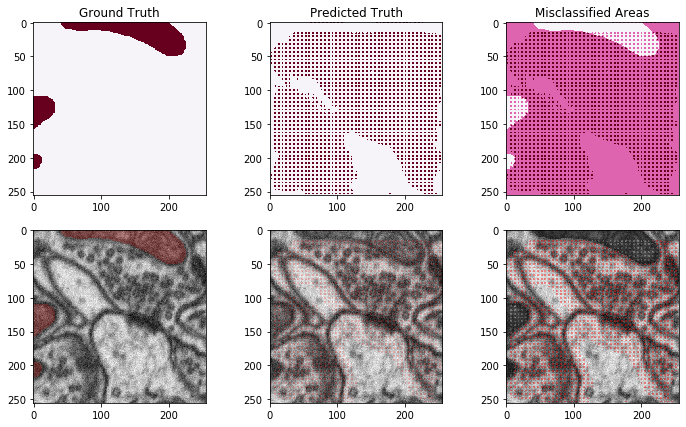

In [22]:
index = 0
_,H,W,_ = testing_inputs.shape
image = testing_inputs[test_inds[index],:,:,0]
predict_mask = np.zeros(shape=(H,W,4))
test_mask = np.zeros(shape=(H,W,4))
oops_mask = np.zeros(shape=(H,W,4))

predict_mask[:,:,0] = model.predict(testing_inputs[test_inds,:,:,:]-training_mean)[index][:,:,0] > 0.5
predict_mask[:,:,3] = 0.2*(predict_mask[:,:,0]>0.)

test_mask[:,:,0] = testing_ground_truth[test_inds[index],:,:,0]
test_mask[test_mask>1] = 1
test_mask[:,:,3] = 0.2*(test_mask[:,:,0]>0.)

oops_mask[:,:,0] = 0.5*(predict_mask[:,:,0] - test_mask[:,:,0])+0.5
oops_mask[:,:,3] = 0.4*((oops_mask[:,:,0]>0.51))+0.4*(oops_mask[:,:,0]<0.49)

fig = plt.figure(figsize=[12,7])
ax1 = plt.subplot(2,3,1)
ax1.imshow(test_mask[:,:,0],cmap='PuRd')
ax1.set_title('Ground Truth')

ax2 = plt.subplot(2,3,2)
ax2.imshow(predict_mask[:,:,0],cmap='PuRd')
ax2.set_title('Predicted Truth')

ax3 = plt.subplot(2,3,3)
ax3.imshow(oops_mask[:,:,0],cmap='PuRd')
ax3.set_title('Misclassified Areas')

ax4 = plt.subplot(2,3,4)
ax4.imshow(image,cmap = 'gray',label='real_image')
ax4.imshow(test_mask,cmap='Reds')

ax5 = plt.subplot(2,3,5)
ax5.imshow(image,cmap = 'gray',label='predicted_image')
ax5.imshow(predict_mask,cmap='Reds')

ax6 = plt.subplot(2,3,6)
ax6.imshow(image,cmap = 'gray',label='mistakes_image')
ax6.imshow(oops_mask,cmap='PuRd')

plt.show()